In [3]:
# sub_categories = ["All_Beauty", "Subscription_Boxes", "Magazine_Subscriptions", "Health_and_Personal_Care", "Handmade_Products", "Gift_Cards", "Digital_Music", "Appliances"]
sub_categories = ["Gift_Cards", "Digital_Music", "Magazine_Subscriptions", "Subscription_Boxes"]

In [45]:
from datasets import load_dataset

review_datasets_list = []
meta_dataset_list = []
for sub_cat in sub_categories:
    print(f"Loading review dataset for sub category {sub_cat}")
    sub_cat_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_review_{sub_cat}", split="full", trust_remote_code=True)
    review_datasets_list.append(sub_cat_dataset.add_column('category', [sub_cat]*len(sub_cat_dataset)))
    
    print(f"Loading metadata dataset for sub category {sub_cat}")
    sub_cat_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_{sub_cat}", split="full", trust_remote_code=True)
    meta_dataset_list.append(sub_cat_dataset)

Loading review dataset for sub category Gift_Cards
Loading metadata dataset for sub category Gift_Cards
Loading review dataset for sub category Digital_Music
Loading metadata dataset for sub category Digital_Music
Loading review dataset for sub category Magazine_Subscriptions
Loading metadata dataset for sub category Magazine_Subscriptions
Loading review dataset for sub category Subscription_Boxes
Loading metadata dataset for sub category Subscription_Boxes


In [46]:
sub_cat_dataset

Dataset({
    features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
    num_rows: 641
})

In [47]:
from datasets import concatenate_datasets

In [48]:
review_dataset = concatenate_datasets(review_datasets_list)
meta_dataset = concatenate_datasets(meta_dataset_list)

In [49]:
review_dataset, meta_dataset

(Dataset({
     features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'category'],
     num_rows: 370557
 }),
 Dataset({
     features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
     num_rows: 75706
 }))

In [50]:
meta_dataset = meta_dataset.rename_column("title", "item_title")

In [51]:
len(review_dataset)

370557

In [52]:
meta_df = meta_dataset.to_pandas()
review_df = review_dataset.to_pandas()

In [53]:
review_selected_cols = ["rating", "title", "text", "parent_asin", "user_id", "timestamp", "helpful_vote", "verified_purchase", "category"]
meta_selected_cols = ["main_category", "item_title", "average_rating", "rating_number", "features", "description", "price", "store", "categories", "details", "parent_asin"]
merge_df = review_df[review_selected_cols].merge(meta_df[meta_selected_cols], on="parent_asin")

In [54]:
merge_df["title_text"] = merge_df.apply(lambda x: f"{x['title']} {x['text']}".lower(), axis=1)

In [55]:
sub_categories

['Gift_Cards', 'Digital_Music', 'Magazine_Subscriptions', 'Subscription_Boxes']

In [56]:
len(merge_df)

370557

In [59]:
from datasets.features import Value, Sequence, Features

features = Features({
     'rating': Value(dtype='float64', id=None),
     'title': Value(dtype='string', id=None),
     'title_text': Value(dtype='string', id=None),
     'text': Value(dtype='string', id=None),
     'parent_asin': Value(dtype='string', id=None),
     'user_id': Value(dtype='string', id=None),
     'timestamp': Value(dtype='int64', id=None),
     'helpful_vote': Value(dtype='int64', id=None),
     'verified_purchase': Value(dtype='bool', id=None),
     'main_category': Value(dtype='string', id=None),
     'category': Value(dtype='string', id=None),
     'item_title': Value(dtype='string', id=None),
     'average_rating': Value(dtype='float64', id=None),
     'rating_number': Value(dtype='int64', id=None),
     'features': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'description': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'price': Value(dtype='string', id=None),
     'store': Value(dtype='string', id=None),
     'categories': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'details': Value(dtype='string', id=None)})

In [60]:
from datasets import Dataset, concatenate_datasets
from tqdm.notebook import tqdm

chunk_size = 5000  # Adjust this based on your memory capacity
datasets_list = []

for i in tqdm(range(0, len(merge_df), chunk_size)):
    chunk = merge_df.iloc[i:i + chunk_size]
    datasets_list.append(Dataset.from_pandas(chunk, features))

# Concatenate all chunks into one dataset
final_dataset = concatenate_datasets(datasets_list)

  0%|          | 0/75 [00:00<?, ?it/s]

In [61]:
sample_dataset = final_dataset.shuffle().select(range(10000))

In [62]:
sample_dataset

Dataset({
    features: ['rating', 'title', 'title_text', 'text', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'main_category', 'category', 'item_title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'store', 'categories', 'details'],
    num_rows: 10000
})

In [63]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
from umap import UMAP
import datasets
import numpy as np
import torch

datasets.logging.set_verbosity_error()

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

In [64]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def embed_sentence_pairs(dataloader, tokenizer, model, disable_tqdm=False):
    review_embeddings  = []
    item_embeddings = []
    feature_embeddings = []

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    model.eval()

    loop = tqdm(dataloader, desc=f"Embedding sentences...", disable=disable_tqdm)
    for data in loop:

        review = [record['title_text'] for record in data]
        # print(f"review batch: {review}")
        encoded_review = tokenizer(review, padding=True, truncation=True, return_tensors='pt')

        # Compute token embeddings
        with torch.no_grad():
            encoded_review = encoded_review.to(device)
            model_review_output = model(**encoded_review)

        # Perform pooling
        pooled_review = mean_pooling(model_review_output, encoded_review['attention_mask']).cpu().numpy()
        review_embeddings.extend(pooled_review)

        
    # Concatenate premise and hypothesis embeddings, as well as their absolute difference
    feature_embeddings = np.array(review_embeddings)
    return feature_embeddings

In [65]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

batch_size = 128

# Place Hugging Face datasets in a PyTorch DataLoader
loader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

# Get embeddings
embeddings = embed_sentence_pairs(loader, tokenizer, model, disable_tqdm=False)

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Embedding sentences...:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
# from sentence_transformers import SentenceTransformer

# transformer = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
# raw_texts = sample_dataset["text"]
# text_embeddings = transformer.encode(raw_texts)

In [70]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.025)  # Set contamination rate
model.fit(embeddings)
anomalies = model.predict(embeddings)

In [71]:
anomalies.sum(), len(anomalies)

(9500, 10000)

In [72]:
anomaly_idxs = np.where(anomalies == -1)[0]
sample_dataset.select(anomaly_idxs).to_pandas().head(5).style

,rating,title,title_text,text,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,category,item_title,average_rating,rating_number,features,description,price,store,categories,details
0,5.000000,Shipped fast,shipped fast gift,Gift,B00ADR2LV6,AG3D3P5T24FP3VZAL7GQLQNBOFEQ,1546453268979,0,True,Gift Cards,Gift_Cards,Amazon.com Gift Card in a Holiday Gift Box (Various Designs),4.900000,185606,"['Gift Card is affixed inside a box' 'Gift amount may not be printed on Gift Cards' 'You can customize the gift amount as desired, for example $36, $54, $72, etc.' 'Gift Card has no fees and no expiration date' 'Gift Card is redeemable towards millions of items storewide at Amazon.com' 'Scan and redeem any Gift Card with a mobile or tablet device via the Amazon App' 'Free One-Day Shipping (where available)' 'Customized gift message, if chosen at check-out, only appears on packing slip and not on the actual gift card or carrier']",[],25.0,Amazon,['Gift Cards' 'Occasions' 'Chanukah'],"{""Package Dimensions"": ""8.19 x 4.41 x 1.3 inches; 1.45 Ounces"", ""Item model number"": ""VariableDenomination"", ""Date First Available"": ""September 16, 2020"", ""Manufacturer"": ""Amazon""}"
1,4.000000,Four Stars,four stars bien,BIen,B00IX1I3G6,AH5X3KDHVQNA6RCWQEVFXDKKMMTQ,1431548081000,1,True,None,Gift_Cards,Amazon Reload,4.700000,143309,"['Add funds to your Amazon Gift Card balance, then use your balance to manage how much you spend while shopping.' 'Save up for a purchase by adding funds to your Gift Card balance.' 'Checkout faster when you reload to your Gift Card balance in advance.' 'Set up Auto-Reload to automatically reload to your Gift Card Balance on a particular date, week, month or when your balance gets low.' 'Reloaded funds never expire and have no fees.' 'Amazon Reload purchases are not refundable or redeemable for cash, except as required by law.']",[],None,Amazon,['Gift Cards' 'Gift Card Recipients' 'For Him'],"{""Item model number"": ""VariableDenomination"", ""Date First Available"": ""April 13, 2021"", ""Manufacturer"": ""Amazon""}"
2,5.000000,Five Stars,five stars great dolly,Great Dolly,B0014WIP6E,AFZYIEDHWJIAKEORZVFRKFJ6OIIQ,1406546117000,0,True,Digital Music,Digital_Music,"Dolly Parton - Backwoods Barbie LIMITED EDITION CD - Includes Bonus Tracks ""Jolene (Live)"" and ""Two Doors Down (Live)""",5.000000,16,[],[],12.99,Dolly Parton Format: Audio CD,[],{}
3,5.000000,Gift Cards,gift cards great for anyone,Great for anyone,B00OOKDO4Q,AGO6QQNPFJCQXLQ4QTYYTF6MRXNA,1578524086107,0,True,Gift Cards,Gift_Cards,App Store & iTunes Gift Cards,4.800000,7430,"['One card, millions of ways to enjoy it. Use for apps, games, music, movies, and iCloud.' 'Available in amounts of $50, $100, $200 and $40 Multipack.' 'Gift cards delivered by mail.' 'Redemption: Online.' 'No returns and no refunds on gift cards.' 'Terms apply. See below.' 'Good for the US iTunes Store only.' 'For use on iTunes, Apple Music and App Store in US only. Not valid for other payments.' 'Includes an envelope for easy gift-giving.']","['One card, millions of ways to enjoy it. Use the App Store & iTunes Gift Card to get apps, games, music, movies and TV shows. Available in a variety of denominations - spend it on in-app content, books, TV show subscriptions or even iCloud storage to secure files from all your Apple devices.']",None,Apple,['Gift Cards' 'Gift Card Categories' 'Video Games & Online Games'],"{""Brand"": ""Apple"", ""Memory Storage Capacity"": ""2 GB"", ""Special Feature"": ""Light Weight"", ""Item Weight"": ""0.02 Pounds"", ""Is Discontinued By Manufacturer"": ""No"", ""Product Dimensions"": ""9 x 5 x 0.01 inches; 0.32 Ounces"", ""Date First Available"": ""October 8, 2014"", ""Manufacturer"": ""UnAssigned""}"
4,5.000000,Great gift,great gift basic gift car,Basic gift car,B071X4ZX3X,AFTCQECWBRCRUCE4P2MYEHDI5F6Q,1603052101739,0,True,Gift Cards,Gift_Cards,Amazon.com Gift Card in a Mini Envelope,4.900000,105948,"['Gift Card is affixed inside a mini envel

In [73]:
from cleanlab.outlier import OutOfDistribution

# Get outlier scores for each of the data feature embeddings
ood = OutOfDistribution()
outlier_scores = ood.fit_score(features=embeddings)

Fitting OOD estimator based on provided features ...


In [74]:
top_outlier_idxs = (outlier_scores).argsort()[:15]
top_outlier_subset = sample_dataset.select(top_outlier_idxs)
top_outlier_subset.to_pandas().head()

,rating,title,title_text,text,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,category,item_title,average_rating,rating_number,features,description,price,store,categories,details
0,5.0,Conforme,conforme conforme,Conforme,B071X4ZX3X,AFKHIUGRDIZYUI3EZYRA5EQUJH4Q,1563019843340,0,True,Gift Cards,Gift_Cards,Amazon.com Gift Card in a Mini Envelope,4.9,105948,"[Gift Card is affixed inside a mini envelope, ...",[Amazon.com Gift Cards are the perfect way to ...,10.0,Amazon,"[Gift Cards, Gift Card Recipients, For Him]","{""Product Dimensions"": ""0.3 x 4.4 x 3.8 inches..."
1,5.0,B3 usb c and hdmi adapter,b3 usb c and hdmi adapter works incredibly wit...,works incredibly with MacBook Pro 2020 samsung...,B018F4M89S,AFKDTMNDRTRE2Z4XZ24MUADYKWSQ,1660924029170,0,False,Gift Cards,Gift_Cards,Amazon.com Gift Card in a Reveal (Various Desi...,4.9,80974,"[Gift Card is affixed inside a reveal product,...",[Amazon.com Gift Cards are the perfect way to ...,20.0,Amazon,"[Gift Cards, Occasions, Christmas]","{""Package Dimensions"": ""4.37 x 4.21 x 0.51 inc..."
2,5.0,kicker speaker,kicker speaker kicker speaker that i bought is...,kicker speaker that i bought is not what i hav...,B005S28ZES,AHYUNFZW3NHAJ5NUI76FOHKGKU3A,1338627057000,0,False,Gift Cards,Gift_Cards,Amazon.com Gift Card in a Gift Box (Various Th...,4.9,4918,[Gift Card is nested inside a specialty gift b...,[Amazon.com Gift Cards are the perfect way to ...,25.0,Amazon,"[Gift Cards, Gift Card Recipients, For Him]","{""Product Dimensions"": ""1 x 4.4 x 4.8 inches; ..."
3,1.0,Ridiculously stupid,ridiculously stupid all that needs to be said.,All that needs to be said.,B001U5SPJW,AFN25EN6FJEJ6CLTQNYSMOLRWQNA,1584729525624,1,False,Magazine Subscriptions,Magazine_Subscriptions,The New Yorker Print Magazine,4.5,4049,[],[],None,Condé Nast Publications,"[Magazine Subscriptions, Entertainment & Pop C...","{""Date First Available"": ""February 27, 2009"", ..."
4,5.0,Basketball John,basketball john basketball john,Basketball John,9573459833,AEACLJRJ7BJPQC4TOB3Z6BSAWMFQ,1624840746006,0,True,Digital Music,Digital_Music,Get Jazzed - Utah Jazz Collectible CD,5.0,1,[],[],39.95,Robert Lund (Author) Format: Audio CD,[],"{""Package Dimensions"": ""5.55 x 4.8 x 0.2 inche..."


In [77]:
top_outlier_subset.to_pandas()[["rating", "title", "text", "item_title", "store", "details"]].head(10).style

,rating,title,text,item_title,store,details
0,5.000000,Conforme,Conforme,Amazon.com Gift Card in a Mini Envelope,Amazon,"{""Product Dimensions"": ""0.3 x 4.4 x 3.8 inches; 0.63 Ounces"", ""Item model number"": ""VariableDenomination"", ""Date First Available"": ""June 26, 2017"", ""Manufacturer"": ""Amazon"", ""Domestic Shipping"": ""Currently, item can be shipped only within the U.S. and to APO/FPO addresses. For APO/FPO shipments, please check with the manufacturer regarding warranty and support issues."", ""International Shipping"": ""This item is not eligible for international shipping. Learn More""}"
1,5.000000,B3 usb c and hdmi adapter,works incredibly with MacBook Pro 2020 samsung curved monitor,Amazon.com Gift Card in a Reveal (Various Designs),Amazon,"{""Package Dimensions"": ""4.37 x 4.21 x 0.51 inches; 0.63 Ounces"", ""Item model number"": ""VariableDenomination"", ""Date First Available"": ""November 21, 2017"", ""Manufacturer"": ""Amazon"", ""Domestic Shipping"": ""Currently, item can be shipped only within the U.S. and to APO/FPO addresses. For APO/FPO shipments, please check with the manufacturer regarding warranty and support issues."", ""International Shipping"": ""This item is not eligible for international shipping. Learn More""}"
2,5.000000,kicker speaker,kicker speaker that i bought is not what i have expect to be. if i could possibly exchange it with a different size of speaker then i will be satisfied.,Amazon.com Gift Card in a Gift Box (Various Thank You Designs),Amazon,"{""Product Dimensions"": ""1 x 4.4 x 4.8 inches; 1.13 Ounces"", ""Item model number"": ""VariableDenomination"", ""Date First Available"": ""November 29, 2016"", ""Manufacturer"": ""Amazon"", ""Domestic Shipping"": ""Currently, item can be shipped only within the U.S. and to APO/FPO addresses. For APO/FPO shipments, please check with the manufacturer regarding warranty and support issues."", ""International Shipping"": ""This item is not eligible for international shipping. Learn More""}"
3,1.000000,Ridiculously stupid,All that needs to be said.,The New Yorker Print Magazine,Condé Nast Publications,"{""Date First Available"": ""February 27, 2009"", ""Manufacturer"": ""Cond\u00e9 Nast Publications""}"
4,5.000000,Basketball John,Basketball John,Get Jazzed - Utah Jazz Collectible CD,Robert Lund (Author) Format: Audio CD,"{""Package Dimensions"": ""5.55 x 4.8 x 0.2 inches; 3.32 Ounces"", ""Date First Available"": ""December 5, 2009""}"
5,5.000000,Gary Moore kicks ass!,Gary Moore kicks ass!,Live in Stockholm 1987,Gary Moore Format: Audio CD,"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inches; 2.21 Ounces"", ""Manufacturer"": ""101 DISTRIBUTION"", ""Date First Available"": ""May 28, 2011"", ""Label"": ""101 DISTRIBUTION"", ""Number of discs"": ""1""}"
6,5.000000,Genial,Genial,Amazon Reload,Amazon,"{""Item model number"": ""VariableDenomination"", ""Date First Available"": ""April 13, 2021"", ""Manufacturer"": ""Amazon""}"
7,3.000000,No difference,There is no difference in the appearance of my skin or eyes,"Sonage Skincare - Beauty Skincare Subscription Box, Discover Full-Sized Professional Spa Grade Products & Tools",SONAGE,{}
8,1.000000,Sjw garbage,sjw garbage,Wired Print Magazine,Conde Nast Publications,"{""Date First Available"": ""February 27, 2009""}"
9,5.000000,Na,Was used as a prize.,Amazon.com Gift Card in a Congratulations or Graduation Style Gift Box (Various Designs),Amazon,{}


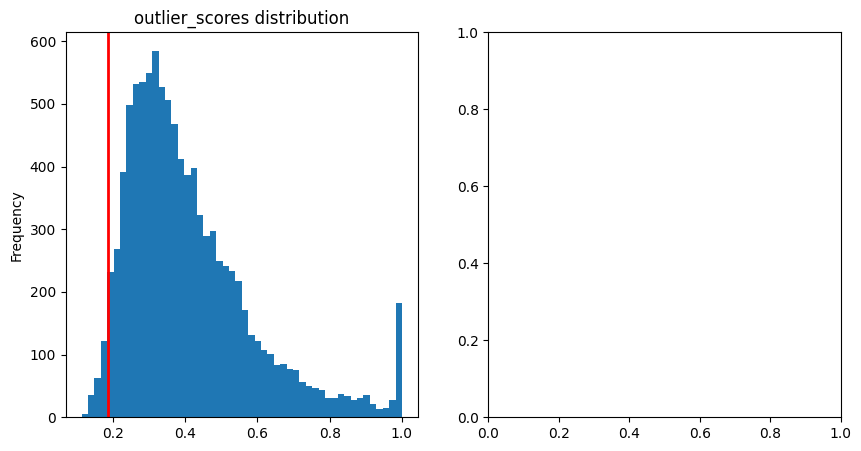

In [78]:
import matplotlib.pyplot as plt

threshold = np.percentile(outlier_scores, 2.5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt_range = [outlier_scores.min(), outlier_scores.max()]

axes[0].hist(outlier_scores, range=plt_range, bins=50)
axes[0].set(title='outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=threshold, color='red', linewidth=2)

In [79]:

# Get embeddings of test examples whose outlier scores are below the threshold

sorted_ids = outlier_scores.argsort()
outlier_scores = outlier_scores[sorted_ids]
outlier_ids = sorted_ids[outlier_scores < threshold]

selected_outlier_subset = sample_dataset.select(outlier_ids)
selected_outlier_subset.to_pandas().tail(15)

,rating,title,title_text,text,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,category,item_title,average_rating,rating_number,features,description,price,store,categories,details
235,5.0,Do again,do again loved by all,Loved by all,B077N4CNVJ,AEFSRZH3ZXHK7AI7BYY7ZCJ4PRKQ,1618945925019,0,True,Gift Cards,Gift_Cards,Amazon.com Gift Card in Various Gift Boxes,4.9,104005,"[Gift Card is affixed inside a gift box, Gift ...",[],25.0,Amazon,"[Gift Cards, Amazon Incentives Brand Guidelines]","{""Package Dimensions"": ""4.65 x 3.7 x 0.67 inch..."
236,5.0,lasting,lasting work well,work well,B000K14M30,AE3JOTC7Z76IWN73E6NBZYEE2BZA,1541107523877,0,True,Magazine Subscriptions,Magazine_Subscriptions,Superb Crosswords Jumbo,4.5,33,[],[],None,Kappa Publishers Group,"[Magazine Subscriptions, Professional & Educat...","{""Date First Available"": ""November 3, 2006""}"
237,5.0,my wind rag of choice for 10 years,my wind rag of choice for 10 years whether you...,"Whether you're new to the sport or a ripping, ...",B000063XJO,AFEDUSJLF4Q4KHPRL4DE5W5GTCUQ,1044909112000,1,False,Magazine Subscriptions,Magazine_Subscriptions,Wind Surfing,4.0,2,[],[],None,None,"[Magazine Subscriptions, Sports, Recreation & ...","{""Date First Available"": ""March 14, 2023""}"
238,1.0,?,? didn’t buy this or get this,Didn’t buy this or get this,BT00CTOUNS,AFONDFSSP2KNEL2FDPAOHVZ5S4AQ,1587061299964,0,True,Gift Cards,Gift_Cards,Amazon.com Gift Card in a Greeting Card (Vario...,4.8,13831,[Gift Card is affixed inside a greeting card w...,[Amazon.com Gift Cards are the perfect way to ...,None,Amazon,"[Gift Cards, Gift Card Recipients, For Him]","{""Package Dimensions"": ""8.5 x 5.6 x 0.1 inches..."
239,5.0,What could be better?,what could be better? vintage stones. what cou...,Vintage Stones. What could be better?,B00WM8BSZE,AHBJKG4WUT5A4OLU64WCKC2U5EWQ,1493717858000,1,True,Digital Music,Digital_Music,The Rolling Stones : Previously Unreleased,4.7,19,[],"[The Rolling Stones - Previously Unreleased, T...",None,"The Rolling Stones (Artist, Composer) Form...",[],"{""Is Discontinued By Manufacturer"": ""No"", ""Dat..."
240,5.0,The Great Governor Jimmie H. Davis,the great governor jimmie h. davis governor da...,Governor Davis; rose from a Sharecroppers son ...,B0006GP3BO,AF2MA5KXSIRH2YC4XRUIIZYGACTQ,1224647235000,2,True,Digital Music,Digital_Music,The Best of Jimmie Davis; Gospel Favorites,4.9,18,[],"[Jimmie Davis - Born Sept. 11, 1899 - Died Nov...",29.98,Jimmie Davis Format: Audio CD,[],"{""Is Discontinued By Manufacturer"": ""No"", ""Pac..."
241,1.0,PIN so difficult to scratch off,pin so difficult to scratch off the pin was so...,"the PIN was so difficult to scratch off, I alm...",B00GOLH2S2,AEDESGEE7CELJ2XUJRVGVRARSDZA,1642897180954,0,True,Gift Cards,Gift_Cards,Staples Gift Card,4.8,351,[Staples Gift Cards - Giving the perfect gift ...,[Giving the perfect gift has never been easier...,50.0,STAPLES,"[Gift Cards, Gift Card Categories, Electronics...","{""Package Dimensions"": ""5.2 x 3.98 x 0.47 inch..."
242,5.0,Myles Ahead,"myles ahead smooth transaction, as described!","Smooth transaction, as described!",B00745BIKK,AGOCPSB2CMNAUAHYKAWTXOLVAXJA,1660794112102,0,True,Digital Music,Digital_Music,Alannah Myles- Rockinghorse,4.6,93,[],[],1.51,Alannah Myles Format: Audio CD,[],"{""Item Weight"": ""3.03 Ounces"", ""Date First Ava..."
243,5.0,good,good it will provide you with a structure to f...,It will provide you with a structure to follow...,B07TVZQVXJ,AFOGLDZUY4T26AO2B7CPTMDCQQYQ,1568435250520,0,True,Digital Music,Digital_Music,PMP Project Management Professional 4 Hour Aud...,4.1,6,[],[],None,Format: Audio CD,[],"{""Package Dimensions"": ""5.9 x 5.4 x 0.7 inches..."
244,5.0,A Worthy Piece of Offenbachiana,a worthy piece of offenbachiana offenbach was ...,"Offenbach was a cellist, and these are lovely ...",B000KS2EWY,AG7KUYPF2LVYV4JPK46MFQM7GKCQ,1483127405000,0,True,Digital Music,Digital_Music,Jacques Offenbach: Concerto Rondo; Overture to...,3.5,2,[],[],17.9

In [80]:
selected_outlier_subset.to_pandas().verified_purchase.value_counts()

verified_purchase
True     198
False     52
Name: count, dtype: int64

In [81]:
selected_outlier_subset.to_pandas().rating.value_counts()

rating
5.0    140
1.0     37
4.0     35
3.0     25
2.0     13
Name: count, dtype: int64

In [87]:
cat_2_idx = {cat:idx for idx, cat in enumerate(sub_categories)}

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


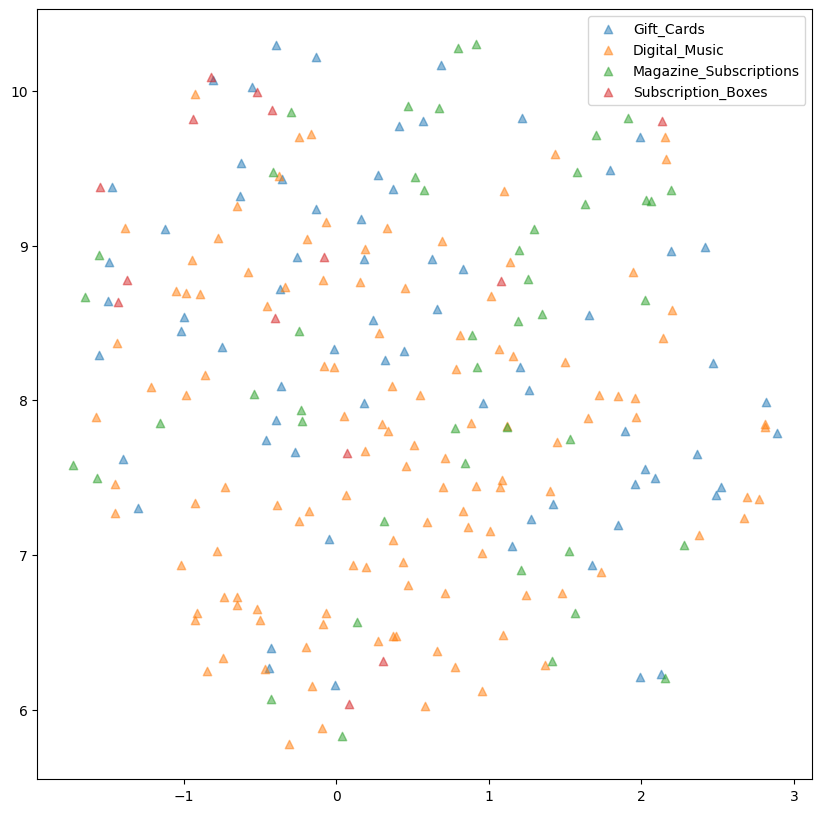

In [88]:
# Get embeddings of selected outliers
selected_outlier_subset_embeddings = embeddings[outlier_ids]

# Reduce dimensionality with UMAP
umap_fit = UMAP(n_components=2, n_neighbors=8, random_state=SEED)
selected_outlier_subset_embeddings_umap = umap_fit.fit_transform(selected_outlier_subset_embeddings)

# Set plot labels
genre_labels = np.array([cat_2_idx.get(x, 0) for x in selected_outlier_subset["category"]])

# Plot reduced embeddings
plt.figure(figsize=(10, 10))
x_plot, y_plot = selected_outlier_subset_embeddings_umap[:, 0], selected_outlier_subset_embeddings_umap[:, 1]

for i, genre in enumerate(cat_2_idx.keys()):
    x, y = x_plot[genre_labels == i], y_plot[genre_labels == i]
    if genre in mismatched_labels:
        # Mismatched genres are filled circles
        plt.scatter(x, y, label=genre)
    else:
        # Matched genres are transparent triangles
        plt.scatter(x, y, label=genre, alpha=0.5, marker="^")
plt.legend()

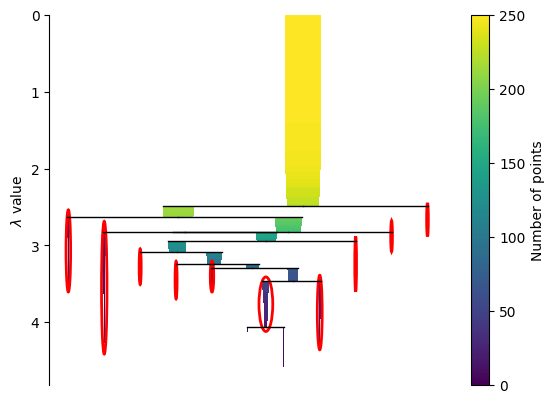

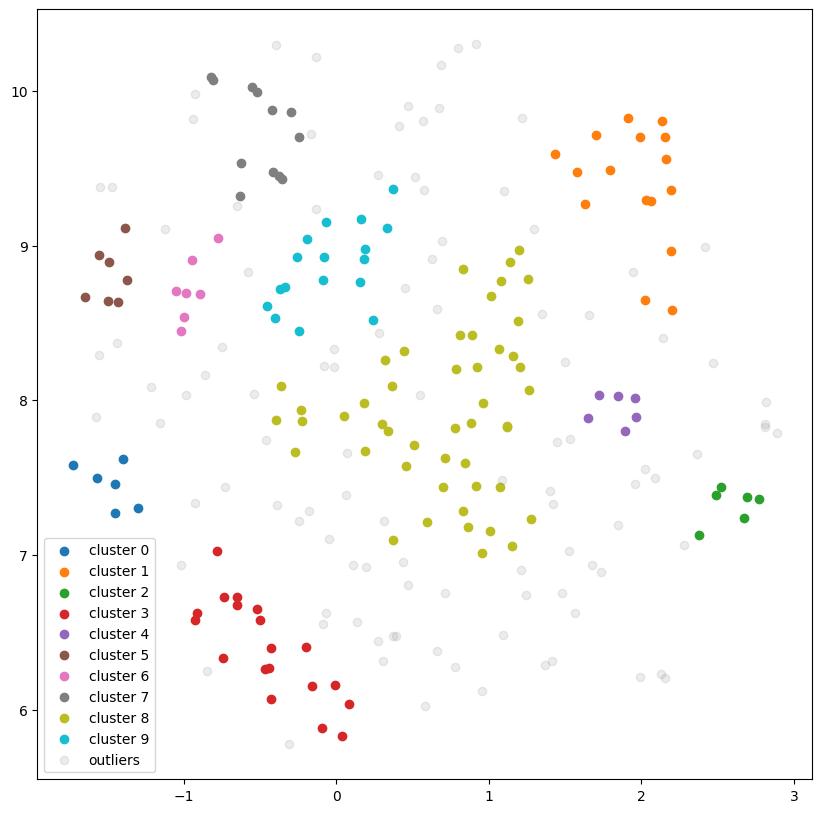

In [89]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=6, min_samples=4)
clusterer.fit(selected_outlier_subset_embeddings_umap)
cluster_labels = clusterer.labels_

clusterer.condensed_tree_.plot(select_clusters=True)

# plot each set of points in a different color
plt.figure(figsize=(10, 10))
for i in np.unique(cluster_labels):
    if i != -1:
        x, y = x_plot[cluster_labels == i], y_plot[cluster_labels == i]
        plt.scatter(x, y, label=f"cluster {i}")

# Plot outliers in gray
x, y = x_plot[cluster_labels == -1], y_plot[cluster_labels == -1]
plt.scatter(x, y, label="outliers", color="gray", alpha=0.15)
plt.legend()

In [96]:
# def detect_ood_outliers(category, embds):
#     ood = OutOfDistribution()
#     outlier_scores = ood.fit_score(features=embds)

#     top_outlier_idxs = (outlier_scores).argsort()
#     top_outlier_subset = sample_dataset.select(top_outlier_idxs)
#     return top_outlier_subset.to_pandas().head(15)

In [98]:

# outliers_dfs = {}
# grouped = sample_df.groupby('category')
# for c in grouped.groups:
#     sub_df = grouped.get_group(c)
#     group_embds = embeddings[grouped.groups[c],:]
#     cat = sub_df.category.iloc[0]
#     outliers_dfs[cat] = detect_ood_outliers(cat, group_embds)

Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...
Fitting OOD estimator based on provided features ...


In [91]:
from sklearn.manifold import TSNE
import pandas as pd

tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings)

df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = sample_dataset["category"]
df_tsne

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


,TSNE1,TSNE2,Class Name
0,-58.280628,-25.814262,Gift_Cards
1,26.839708,26.473104,Digital_Music
2,-65.751663,-18.000137,Gift_Cards
3,11.242936,-53.135578,Gift_Cards
4,8.910241,50.501801,Digital_Music
...,...,...,...
9995,-1.967120,-47.539310,Gift_Cards
9996,-44.656044,39.047913,Digital_Music
9997,17.237881,-50.622730,Gift_Cards
9998,9.829696,-27.361477,Gift_Cards


In [92]:
def get_centroids(df_tsne):
    # Get the centroid of each cluster
    centroids = df_tsne.groupby('Class Name').mean()
    return centroids

centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
Digital_Music,-0.093244,36.265388
Gift_Cards,6.187124,-27.352982
Magazine_Subscriptions,-19.954227,-0.220821
Subscription_Boxes,9.834749,-2.537218


In [93]:
def get_embedding_centroids(df, embds):
    emb_centroids = dict()
    grouped = df.groupby('category')
    for c in grouped.groups:
        sub_df = grouped.get_group(c)
        emb_centroids[c] = embds[grouped.groups[c],:].mean(axis=0)

    return emb_centroids

emb_c = get_embedding_centroids(sample_df, embeddings)

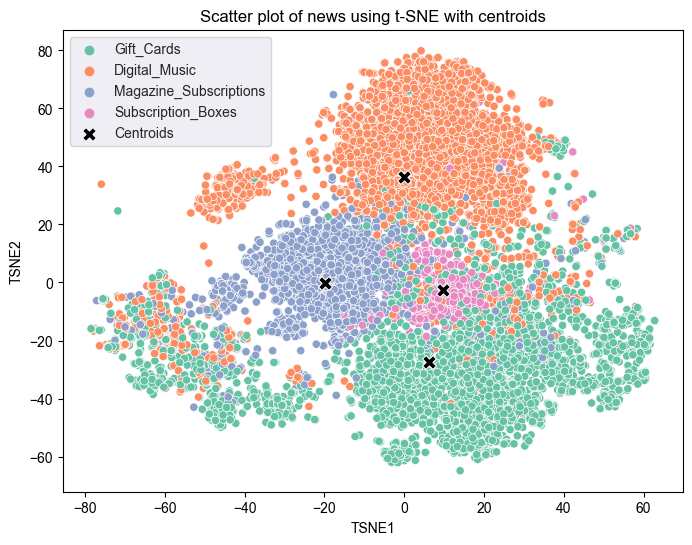

In [94]:
import seaborn as sns

# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# leg = ax.legend()
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

In [291]:
# tsne = TSNE(random_state=0, n_iter=1000)
# tsne_results = tsne.fit_transform(text_embeddings)

# df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
# df_tsne['Class Name'] = sample_dataset["main_category"]
# df_tsne

# emb_c = get_embedding_centroids(sample_df, text_embeddings)
# # Plot the centroids against the cluster
# fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
# sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
# sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
# sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# # leg = ax.legend()
# # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.title('Scatter plot of news using t-SNE with centroids')
# plt.xlabel('TSNE1')
# plt.ylabel('TSNE2');

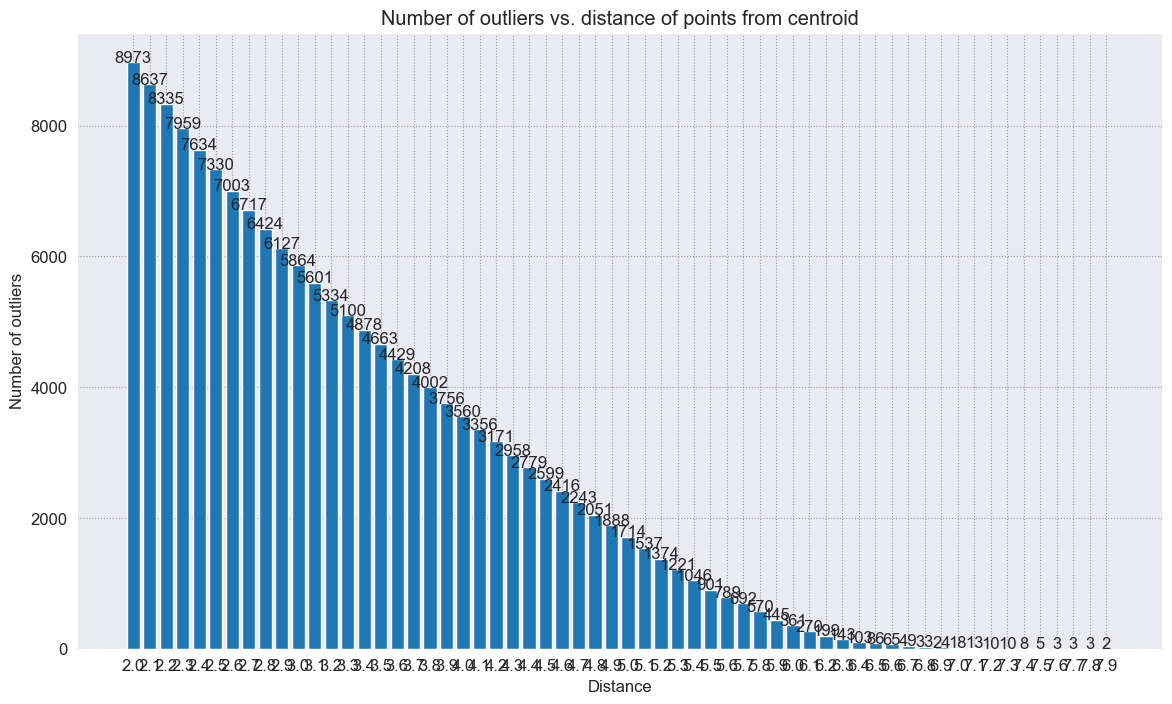

In [107]:
def calculate_euclidean_distance(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
    for idx, row in df.iterrows():
        class_name = row['category'] # Get class name of row
        if not class_name:
            continue
        # Compare centroid distances
        dist = calculate_euclidean_distance(embeddings[idx,:],
                                            emb_centroids[class_name])
        df.at[idx, 'Outlier'] = dist > radius

    return len(df[df['Outlier'] == True])

range_ = np.arange(2, 8, 0.1).round(decimals=2).tolist()
num_outliers = []
for i in range_:
    num_outliers.append(detect_outlier(sample_df, emb_c, i))

# Plot range_ and num_outliers
fig = plt.figure(figsize = (14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
    plt.text(i, num_outliers[i], num_outliers[i], ha = 'center')

plt.show()

In [108]:
RADIUS = 5
detect_outlier(sample_df, emb_c, RADIUS)
df_outliers = sample_df[sample_df['Outlier'] == True]
df_outliers.head()

,rating,title,title_text,text,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,...,item_title,average_rating,rating_number,features,description,price,store,categories,details,Outlier
0,5.0,Five Stars,five stars as advertised,as advertised,B00IX1I3G6,AF4PEJ5YCPKLUM522DJAOEXRDBYQ,1509907982201,0,True,None,...,Amazon Reload,4.7,143309,"[Add funds to your Amazon Gift Card balance, t...",[],38.503569,Amazon,"[Gift Cards, Gift Card Recipients, For Him]","{""Item model number"": ""VariableDenomination"", ...",True
15,5.0,Shipped fast,shipped fast gift,Gift,B00ADR2LV6,AG3D3P5T24FP3VZAL7GQLQNBOFEQ,1546453268979,0,True,Gift Cards,...,Amazon.com Gift Card in a Holiday Gift Box (Va...,4.9,185606,"[Gift Card is affixed inside a box, Gift amoun...",[],25.000000,Amazon,"[Gift Cards, Occasions, Chanukah]","{""Package Dimensions"": ""8.19 x 4.41 x 1.3 inch...",True
20,5.0,Five Stars,five stars good,Good,B00IX1I3G6,AEIYFYIN7TXPCFVL2ROPR4S4MAXQ,1473869183000,0,True,None,...,Amazon Reload,4.7,143309,"[Add funds to your Amazon Gift Card balance, t...",[],38.503569,Amazon,"[Gift Cards, Gift Card Recipients, For Him]","{""Item model number"": ""VariableDenomination"", ...",True
24,5.0,Five Stars,five stars good,Good,B00IX1I3G6,AE5KYLHCU7QTCTFXVLQS5PGAJIUA,1520898770156,0,True,None,...,Amazon Reload,4.7,143309,"[Add funds to your Amazon Gift Card balance, t...",[],38.503569,Amazon,"[Gift Cards, Gift Card Recipients, For Him]","{""Item model number"": ""VariableDenomination"", ...",True
44,4.0,Four Stars,four stars bien,BIen,B00IX1I3G6,AH5X3KDHVQNA6RCWQEVFXDKKMMTQ,1431548081000,1,True,None,...,Amazon Reload,4.7,143309,"[Add funds to your Amazon Gift Card balance, t...",[],38.503569,Amazon,"[Gift Cards, Gift Card Recipients, For Him]","{""Item model number"": ""VariableDenomination"", ...",True


In [109]:
sample_df.verified_purchase.value_counts()

verified_purchase
True     8388
False    1612
Name: count, dtype: int64

In [110]:
df_outliers.verified_purchase.value_counts()

verified_purchase
True     1654
False      60
Name: count, dtype: int64

In [111]:
outliers_projected = df_tsne.loc[df_outliers['Outlier'].index]


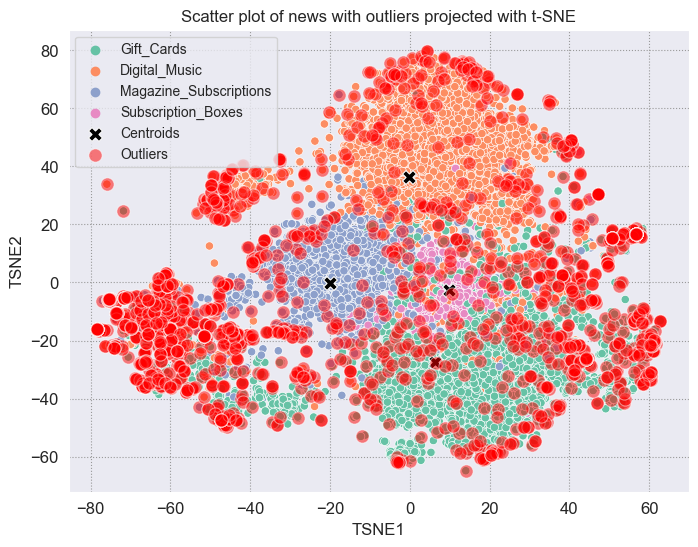

In [112]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# Draw a red circle around the outliers
sns.scatterplot(data=outliers_projected, x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

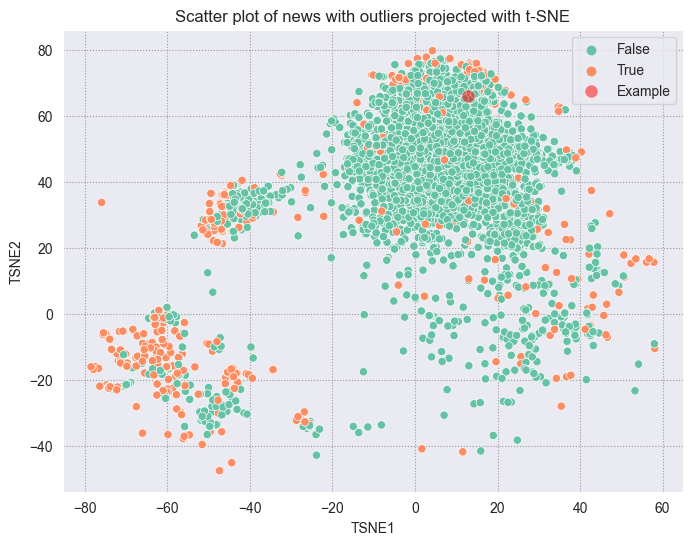

In [114]:
# sample_df[(sample_df['Outlier'] == True) & (df_outliers['main_category'] == "Digital Music")]
df_tsne['Outlier'] = sample_df["Outlier"]
df_tsne['main_category'] = sample_df["main_category"]
df_tsne['rating'] = sample_df["rating"]

fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne[df_tsne['main_category'] == "Digital Music"], x='TSNE1', y='TSNE2', hue='Outlier', palette='Set2');
# Draw a red circle around the outliers
text = "Almost unlistenable. Maybe one decent version out of the entire CD. Not good."
sns.scatterplot(data=df_tsne.loc[sample_df.text.apply(lambda x: x.startswith(text))], x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Example')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

In [115]:
digitla_music_outliers = df_outliers[df_outliers['main_category'] == "Digital Music"]
digitla_music_outliers.rating.value_counts()

rating
5.0    425
4.0     37
1.0     23
3.0     14
2.0      2
Name: count, dtype: int64

In [116]:
digitla_music_outliers[["rating", "verified_purchase", "title", "text", "item_title", "store", "details"]].head(50).style

,rating,verified_purchase,title,text,item_title,store,details
48,5.000000,True,Five Stars,Perfect condition!,Judas Priest Greatest Hits 2 CD Set,Judas Priest Format: Audio CD,"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inches; 2.83 Ounces"", ""Date First Available"": ""March 16, 2013""}"
60,5.000000,True,Hours of music,Daughter loves the CD’s.,55 Greatest Hits of Dolly Parton (3 CD Boxset),Dolly Parton (Artist) Format: Audio CD,"{""Item Weight"": ""6 Ounces"", ""Manufacturer"": ""Sony Music"", ""Date First Available"": ""October 31, 2017"", ""Label"": ""Sony Music""}"
79,5.000000,True,Five Stars,Great Dolly,"Dolly Parton - Backwoods Barbie LIMITED EDITION CD - Includes Bonus Tracks ""Jolene (Live)"" and ""Two Doors Down (Live)""",Dolly Parton Format: Audio CD,{}
90,4.000000,True,Four Stars,Great album!,Ultimate Collection Vol 1 - Sandi Patty,Sandi Patty Format: Audio CD,"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inches; 2.88 Ounces"", ""Manufacturer"": ""Patty Sandi"", ""Item model number"": ""4340700519"", ""Date First Available"": ""May 7, 2014"", ""Label"": ""Patty Sandi"", ""Number of discs"": ""1""}"
91,5.000000,True,Great Seller,Great LP!,I Had a Vision of Heaven - THE COOKE DUET & SONS,The Cooke Duet (Artist),{}
112,5.000000,True,Five Stars,More than 100%,My Heart Would Know I Do/Two Arms Two Lips,Bill Bacon And His Country Gentlemen (Author),"{""Manufacturer"": ""Ozark"", ""Date First Available"": ""March 31, 2010"", ""Label"": ""Ozark""}"
138,5.000000,True,Five Stars,great music and good quality sound,Left In the Vaults Vol. 3,Grateful Dead Format: Audio CD,"{""Package Dimensions"": ""5.75 x 5.08 x 0.47 inches; 3.03 Ounces"", ""Date First Available"": ""February 26, 2008"", ""Number of discs"": ""2""}"
162,2.000000,True,Two Stars,I Cant Find This CD,Best of,Anne Murray Format: Audio CD,"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inches; 2.83 Ounces"", ""Manufacturer"": ""Pegasus"", ""Date First Available"": ""May 14, 2010"", ""Label"": ""Pegasus"", ""Number of discs"": ""1""}"
174,5.000000,True,Five Stars,Great!,S/T CD Us Motown,Original Picture sound track (Performer) Format: Audio CD,"{""Package Dimensions"": ""5.6 x 4.8 x 0.5 inches; 4 Ounces"", ""Item model number"": ""MFR050109606221#VG"", ""Date First Available"": ""June 15, 2007"", ""Number of discs"": ""1""}"
180,5.000000,True,Five Stars,Good cd,Rod Stewart,Rod Stewart (Artist) Format: Audio CD,"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inches; 2.83 Ounces"", ""Manufacturer"": ""International"", ""Date First Available"": ""October 13, 2013"", ""Label"": ""International""}"


In [119]:
import numpy as np

# import matplotlib.pyplot as plt
# for the cluster to save the fig:
import matplotlib
matplotlib.use('Agg')

from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle as sh

from em import em, mv

# framework: outlier or novelty detection
novelty_detection = True

# parameters of the algorithm:
averaging = 100
max_features = 10
n_generated = 100000
alpha_min = 0.9
alpha_max = 0.999
t_max = 0.9
ocsvm_max_train = 10000

np.random.seed(1)

n_samples, n_features = embeddings.shape
n_samples_train = n_samples // 2
n_samples_test = n_samples - n_samples_train

X_train = embeddings[:n_samples_train, :]
X_test = embeddings[n_samples_train:, :]

# define models:
iforest = IsolationForest()
# lof = LocalOutlierFactor(n_neighbors=20, novelty=False)
ocsvm = OneClassSVM()

n_samples, n_features = X_test.shape
em_iforest, mv_iforest = 0, 0
em_lof, mv_lof = 0, 0
em_ocsvm, mv_ocsvm = 0, 0
nb_exp = 0
while nb_exp < averaging:
    features = sh(np.arange(n_features))[:max_features]
    X_train_ = X_train[:, features]
    X_ = X_test[:, features]

    lim_inf = X_.min(axis=0)
    lim_sup = X_.max(axis=0)
    volume_support = (lim_sup - lim_inf).prod()
    if volume_support > 0:
        nb_exp += 1
        t = np.arange(0, 100 / volume_support, 0.001 / volume_support)
        axis_alpha = np.arange(alpha_min, alpha_max, 0.001)
        unif = np.random.uniform(lim_inf, lim_sup,
                                 size=(n_generated, max_features))

        iforest.fit(X_train_)
        # lof.fit(X_train_)
        ocsvm.fit(X_train_[:min(ocsvm_max_train, n_samples_train - 1)])
        print('end of ocsvm training!')
        s_X_iforest = iforest.decision_function(X_)
        # s_X_lof = lof.decision_function(X_)
        s_X_ocsvm = ocsvm.decision_function(X_).reshape(1, -1)[0]

        s_unif_iforest = iforest.decision_function(unif)
        # s_unif_lof = lof.decision_function(unif)
        s_unif_ocsvm = ocsvm.decision_function(unif).reshape(1, -1)[0]

        em_iforest += em(t, t_max, volume_support, s_unif_iforest,
                         s_X_iforest, n_generated)[0]
        mv_iforest += mv(axis_alpha, volume_support, s_unif_iforest,
                         s_X_iforest, n_generated)[0]
        # em_lof += em(t, t_max, volume_support, s_unif_lof, s_X_lof,
        #              n_generated)[0]
        # mv_lof += mv(axis_alpha, volume_support, s_unif_lof,
        #              s_X_lof, n_generated)[0]
        em_ocsvm += em(t, t_max, volume_support, s_unif_ocsvm,
                       s_X_ocsvm, n_generated)[0]
        mv_ocsvm += mv(axis_alpha, volume_support, s_unif_ocsvm,
                       s_X_ocsvm, n_generated)[0]

em_iforest /= averaging
mv_iforest /= averaging
# em_lof /= averaging
# mv_lof /= averaging
em_ocsvm /= averaging
mv_ocsvm /= averaging

with open('result_em_bench_high_unsupervised_with' + str(alpha_min) + '_factorized_with' + str(ocsvm_max_train) + 'ocsvm_' + str(max_features) + '_' + str(averaging) + '_' + '.txt', 'a') as result:
    result.write('em_iforest = ' + str(em_iforest) + '\n')
    # result.write('em_lof = ' + str(em_lof) + '\n')
    result.write('em_ocsvm = ' + str(em_ocsvm) + '\n \n')

    result.write('mv_iforest = ' + str(mv_iforest) + '\n')
    # result.write('mv_lof = ' + str(mv_lof) + '\n')
    result.write('mv_ocsvm = ' + str(mv_ocsvm) + '\n')

end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsvm training!
end of ocsv

In [133]:
ocsvm.decision_function(X_)

array([ 165.77612472,  -87.68784657, -172.06116361, ...,   96.25184643,
         -4.42897224, -132.90770914])

In [135]:
em_iforest, mv_iforest

(2.251723788074405e+28, 0.763323990823464)

In [134]:
em_ocsvm, mv_ocsvm

(4.7760967151366094e+28, 0.3654153112944353)

In [140]:
sample_df.category.values[:n_samples_train]

array(['Gift_Cards', 'Digital_Music', 'Gift_Cards', ..., 'Digital_Music',
       'Digital_Music', 'Gift_Cards'], dtype=object)

In [154]:
selected_indices = random.sample(range(n_samples), n_samples_train)
# list(set(range(n_samples)) - set(selected_indices))

In [155]:
len(selected_indices), n_samples

(5000, 10000)

In [149]:
n_samples, n_features = embeddings.shape

In [ ]:
def get_embedding_centroids(df, embds):
    emb_centroids = dict()
    grouped = df.groupby('category')
    for c in grouped.groups:
        sub_df = grouped.get_group(c)
        emb_centroids[c] = embds[grouped.groups[c],:].mean(axis=0)

    return emb_centroids

In [164]:
sample_df.loc[selected_indices].apply(lambda row: row.name, axis=1)

179      179
217      217
2637    2637
537      537
5550    5550
        ... 
6538    6538
8653    8653
6332    6332
7155    7155
6480    6480
Length: 5000, dtype: int64

In [169]:
unif.shape

(100000, 10)

In [172]:
import random

# parameters of the algorithm:
averaging = 50
max_features = 10
n_generated = 100000
alpha_min = 0.9
alpha_max = 0.999
t_max = 0.9
ocsvm_max_train = 10000

np.random.seed(1)

n_samples, n_features = embeddings.shape
n_samples_train = n_samples // 2
n_samples_test = n_samples - n_samples_train

selected_indices = random.sample(range(n_samples), n_samples_train)
remaining_indices = list(set(range(n_samples)) - set(selected_indices))
X_train = embeddings[selected_indices, :]
X_test = embeddings[remaining_indices, :]
train_df = sample_df.loc[selected_indices]
test_df = sample_df.loc[remaining_indices]


# define models:
iforest = IsolationForest()
# lof = LocalOutlierFactor(n_neighbors=20, novelty=False)
ocsvm = OneClassSVM()

n_samples, n_features = X_test.shape
em_centroids, mv_centroids = 0, 0
nb_exp = 0
while nb_exp < averaging:
    features = sh(np.arange(n_features))[:max_features]
    X_train_ = X_train[:, features]
    centroid_embds = get_embedding_centroids(train_df, embeddings[:, features])
    X_ = X_test[:, features]

    lim_inf = X_.min(axis=0)
    lim_sup = X_.max(axis=0)
    volume_support = (lim_sup - lim_inf).prod()
    print(f"Running experiment number {nb_exp}...")
    if volume_support > 0:
        nb_exp += 1
        t = np.arange(0, 100 / volume_support, 0.001 / volume_support)
        axis_alpha = np.arange(alpha_min, alpha_max, 0.001)
        unif = np.random.uniform(lim_inf, lim_sup,
                                 size=(n_generated, max_features))
        
        s_X_centroids = test_df.apply(lambda row: calculate_euclidean_distance(embeddings[row.name,features], centroid_embds[row.category]), axis=1).values
        s_unif_centroids = test_df.apply(lambda row: calculate_euclidean_distance(unif[row.name,:], centroid_embds[row.category]), axis=1).values

        em_centroids += em(t, t_max, volume_support, s_unif_centroids,
                         s_X_centroids, n_generated)[0]
        mv_centroids += mv(axis_alpha, volume_support, s_unif_centroids,
                         s_X_centroids, n_generated)[0]

em_centroids /= averaging
mv_centroids /= averaging

Running experiment number 0...
Running experiment number 1...
Running experiment number 2...
Running experiment number 3...
Running experiment number 4...
Running experiment number 5...
Running experiment number 6...
Running experiment number 7...
Running experiment number 8...
Running experiment number 9...
Running experiment number 10...
Running experiment number 11...
Running experiment number 12...
Running experiment number 13...
Running experiment number 14...
Running experiment number 15...
Running experiment number 16...
Running experiment number 17...
Running experiment number 18...
Running experiment number 19...
Running experiment number 20...
Running experiment number 21...
Running experiment number 22...
Running experiment number 23...
Running experiment number 24...
Running experiment number 25...
Running experiment number 26...
Running experiment number 27...
Running experiment number 28...
Running experiment number 29...
Running experiment number 30...
Running experiment

In [173]:
em_centroids, mv_centroids

(4.817470332527857e+27, 1.3468540058472285)

In [181]:
%matplotlib inline

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


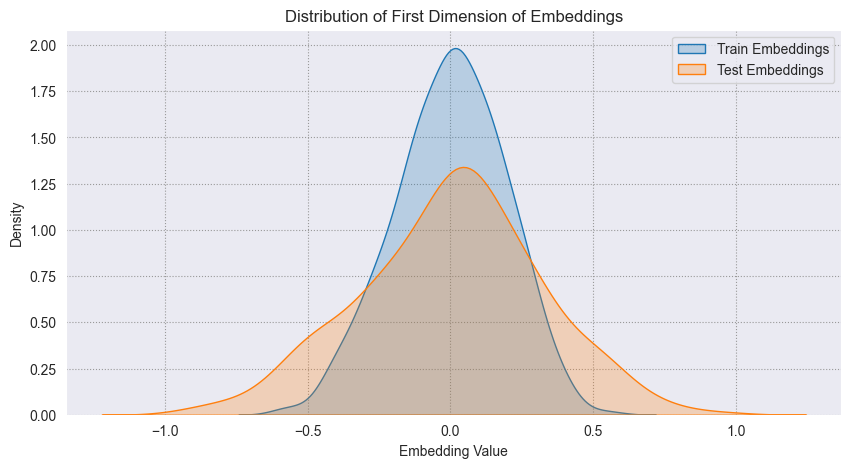

In [183]:
plt.figure(figsize=(10, 5))
sns.kdeplot(X_train[0], label='Train Embeddings', fill=True)
sns.kdeplot(X_test[0], label='Test Embeddings', fill=True)
plt.title('Distribution of First Dimension of Embeddings')
plt.xlabel('Embedding Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
def calculate_euclidean_distance(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
    for idx, row in df.iterrows():
        class_name = row['category'] # Get class name of row
        if not class_name:
            continue
        # Compare centroid distances
        dist = calculate_euclidean_distance(embeddings[idx,:],
                                            emb_centroids[class_name])
        df.at[idx, 'Outlier'] = dist > radius

    return len(df[df['Outlier'] == True])

In [189]:
centroid_embds = get_embedding_centroids(train_df, embeddings)
detect_outlier(test_df, centroid_embds, RADIUS)

855

In [193]:
X_test[test_df["Outlier"] == True].shape

(855, 384)

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


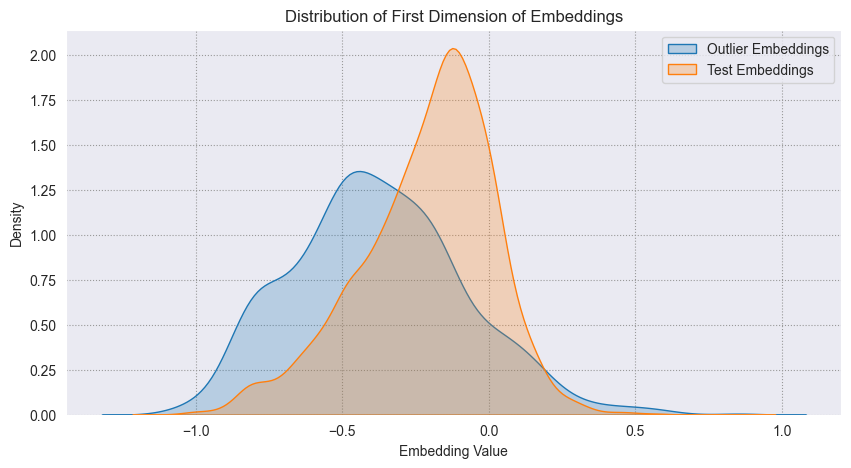

In [199]:
plt.figure(figsize=(10, 5))
sns.kdeplot(X_test[test_df["Outlier"] == True, 0], label='Outlier Embeddings', fill=True)
sns.kdeplot(X_test[:, 0], label='Test Embeddings', fill=True)
plt.title('Distribution of First Dimension of Embeddings')
plt.xlabel('Embedding Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [200]:
tsne_test = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne_test.fit_transform(X_test)

df_tsne_test = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne_test

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


,TSNE1,TSNE2
0,-55.699284,-15.436868
1,4.568448,-39.987179
2,13.090892,45.494610
3,-2.677753,3.917450
4,5.580876,19.270029
...,...,...
4995,-8.263584,53.000561
4996,7.933610,-25.528879
4997,24.342129,-30.364384
4998,-48.492653,18.064962


In [207]:
test_df["Outlier"]

0        True
3       False
4       False
5       False
7       False
        ...  
9992    False
9994    False
9995    False
9996     True
9999     True
Name: Outlier, Length: 5000, dtype: object

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


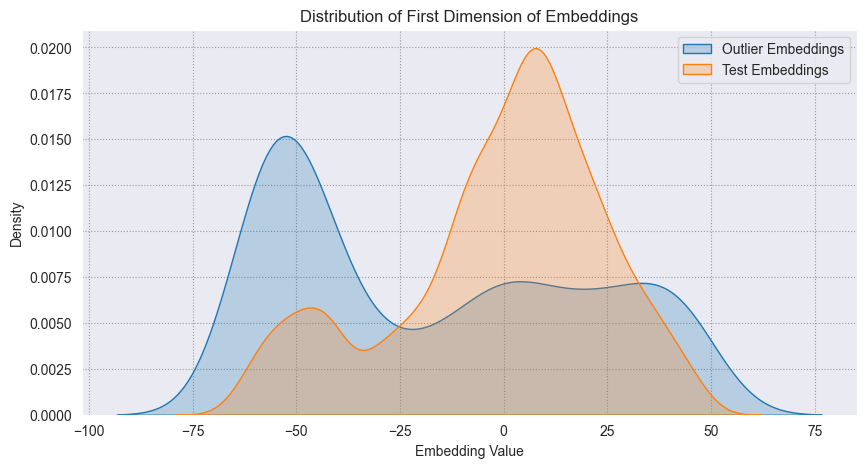

In [213]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df_tsne_test.loc[test_df["Outlier"].values, "TSNE1"].values, label='Outlier Embeddings', fill=True)
sns.kdeplot(df_tsne_test.loc[:, "TSNE1"].values, label='Test Embeddings', fill=True)
plt.title('Distribution of First Dimension of Embeddings')
plt.xlabel('Embedding Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [184]:
import numpy as np
from scipy.stats import ks_2samp

# Compute KS statistic for each dimension
ks_statistics = []
for i in range(X_train.shape[1]):  # iterate over each dimension
    ks_stat, p_value = ks_2samp(X_train[:, i], X_test[:, i])
    ks_statistics.append(ks_stat)

# Average KS statistic across all dimensions
average_ks_statistic = np.mean(ks_statistics)
print(f'Average KS Statistic between train and test sets: {average_ks_statistic}')

Average KS Statistic: 0.016409895833333334


In [214]:
import numpy as np
from scipy.stats import ks_2samp

# Compute KS statistic for each dimension
ks_statistics = []
for i in range(X_test.shape[1]):  # iterate over each dimension
    ks_stat, p_value = ks_2samp(X_test[:, i], X_test[test_df["Outlier"] == True, 0])
    ks_statistics.append(ks_stat)

# Average KS statistic across all dimensions
average_ks_statistic = np.mean(ks_statistics)
print(f'Average KS Statistic between test set and detected outliers: {average_ks_statistic}')

Average KS Statistic between test set and detected outliers: 0.6133869334795321


In [216]:
embeddings.shape

(10000, 384)

In [217]:
mean = np.mean(embeddings, axis=0)
std_dev = np.std(embeddings, axis=0)

In [219]:
mean.shape

(384,)

In [220]:
detector_config = {"encoder": "all-MiniLM-L6-v2", "features": ["title_text"], "radius": RADIUS, "EM": em_centroids, "MV": mv_centroids, "mean_vector":mean, "std_vector":std_dev, **emb_c}

In [221]:
import pickle
with open('detection_config.pkl', 'wb') as fp:
    pickle.dump(detector_config, fp)

In [222]:
std_dev

array([2.3021725e-01, 2.5194502e-01, 1.5524040e-01, 1.9009188e-01,
       2.0379479e-01, 1.7105280e-01, 2.4144001e-01, 2.3227213e-01,
       1.8167686e-01, 1.6261642e-01, 2.1000996e-01, 2.1721539e-01,
       1.6097249e-01, 1.6053349e-01, 2.3173223e-01, 1.8932857e-01,
       2.0594284e-01, 2.1451202e-01, 2.0384532e-01, 1.9813873e-01,
       2.0305848e-01, 1.9965225e-01, 2.2701678e-01, 1.4245859e-01,
       2.0447338e-01, 1.8653846e-01, 1.8236640e-01, 1.7579520e-01,
       2.3199672e-01, 2.2594242e-01, 1.8542480e-01, 2.1482375e-01,
       2.3331487e-01, 1.9178596e-01, 2.4873300e-01, 1.7950271e-01,
       1.7173295e-01, 1.8111904e-01, 1.7124951e-01, 1.5992507e-01,
       1.6047129e-01, 2.7362996e-01, 1.6743919e-01, 1.9374639e-01,
       1.7366847e-01, 1.8508098e-01, 2.7479535e-01, 2.1693419e-01,
       2.0171081e-01, 1.6617322e-01, 2.2889385e-01, 1.6862550e-01,
       1.7890668e-01, 1.7573562e-01, 1.9680257e-01, 2.0276831e-01,
       1.8336776e-01, 2.5317878e-01, 1.4428623e-01, 2.0565888e